## 1. Entorno crudeSched

### 1.1. Establecer el entorno

En primer lugar cargaremos la librería __gym__ e inicializaremos el entorno.

In [1]:
if not ('isColab' in locals()):
    if 'google.colab' in str(get_ipython()):
        print('Running on CoLab')
        !pip install gymnasium
        !wget https://github.com/BaltiBoix/Scheduling/raw/master/tankEnv.py
        isColab = True
    else:
        print('Not running on CoLab')

Running on CoLab
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-02-20 16:23:52--  https://github.com/BaltiBoix/Scheduling/raw/master/tankEnv.py
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BaltiBoix/Scheduling/master/tankEnv.py [following]
--2023-02-20 16:23:52--  https://raw.githubusercontent.com/BaltiBoix/Scheduling/master/tankEnv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22012 (21K) [text/plain]
Saving to: ‘tankEnv.py.1’

tankEnv.py.1        100%[===================>]  21.50K  --.-KB/s    in 0s      

2023-02-20 16:23:52 (

In [1]:
import gymnasium as gym
from gymnasium.spaces import flatten as flat
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy, copy
from collections import namedtuple, deque, OrderedDict
import os
import IPython.display
import sklearn
import sklearn.pipeline
from sklearn.kernel_approximation import RBFSampler

import tankEnv

env = gym.envs.make('crudeTanksEnv-v0')

/usr/local/lib/python3.8/dist-packages/gymnasium/envs/registration.py:435: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gymnasium/utils/passive_env_checker.py:35: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (2, 10)
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gymnasium/utils/passive_env_checker.py:35: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (2, 5)
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gymnasium/utils/passive_env_checker.py:35: User

In [2]:
print('Is torch cuda available?: {}'.format(torch.cuda.is_available()))

Is torch cuda available?: True


In [3]:
env.spec

EnvSpec(id='crudeTanksEnv-v0', entry_point=<class 'tankEnv.crudeTanksEnv'>, reward_threshold=500, nondeterministic=False, max_episode_steps=720, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='crudeTanksEnv', version=0)

In [4]:
class dStat():
    def __init__(self, env, seed=None, scale=True):
        self.dState = deque(maxlen=2)
        self.env = env
        self.seed = seed
        self.scale = scale
        if self.scale:
            self.fitScaler()
        else:
            self.scaler = None
        return
    
    def reset(self):
        self.dState.clear()
        state, data = self.env.reset(seed=self.seed)
        self.dState.append(self.transform(state))
        for _ in range(10):
            action = self.env.action_space.sample()
            if data['actionAvail'][0][action['farmTanks'][0]] and data['actionAvail'][1][action['farmTanks'][1]]:
              break
        self.dState[0] = np.append(self.dState[0], flat(self.env.action_space, action))
        state, reward, done, _, info = self.env.step(action)
        data['actionAvail'] = info['actionAvail']
        self.dState.append(self.transform(state))
        return np.append(*self.dState), data
        
    def step(self, action):
        state, reward, done, truncated, info = self.env.step(action)
        self.dState.append(self.transform(state))
        self.dState[0] = np.append(self.dState[0], flat(self.env.action_space, action))
        return np.append(*self.dState), reward, done, truncated, info
    
    def fitScaler(self):
        observation_examples = np.array([flat(self.env.observation_space, self.env.observation_space.sample())\
                                         for x in range(10000)])
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(observation_examples)
        return
    
    def transform(self, state):
        if self.scaler is None:
            return flat(self.env.observation_space, state)
        return self.scaler.transform([flat(self.env.observation_space, state)])

In [5]:
dSt = dStat(env, scale=False)
state, data = dSt.reset()
stateShape = state.shape[0]

## Actor-Critic method


Basado en el ejemplo de pytorch:  

https://github.com/pytorch/examples/blob/main/reinforcement_learning/actor_critic.py

In [6]:
class AC_actor(torch.nn.Module):

    def __init__(self, env, n_inputs, learning_rate=1e-3, device='cpu'):
        """
        Actor ANN
        """
        super(AC_actor, self).__init__()

        self.n_inputs = n_inputs
        self.learning_rate = learning_rate

        if torch.cuda.is_available() and device=='cuda':
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        self.learning_rate = learning_rate

        # AC Actor
        self.actor = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU()       
        )
        self.actorC = torch.nn.Sequential(
            torch.nn.Linear(256, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),       
            torch.nn.Linear(128, 1, bias=True),
            torch.nn.Softplus()
        )
        self.actorD1 = torch.nn.Sequential(
            torch.nn.Linear(256, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),       
            torch.nn.Linear(128, 13, bias=True),
            torch.nn.Softmax(dim=-1)
        )
        self.actorD2 = torch.nn.Sequential(
            torch.nn.Linear(256, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),       
            torch.nn.Linear(128, 6, bias=True),
            torch.nn.Softmax(dim=-1)
        )

        if self.device == 'cuda':
            self.actor.cuda()
            self.actorC.cuda()
            self.actorD1.cuda()
            self.actorD2.cuda()
        
        self.register_parameter(name='lognu', param=torch.nn.Parameter(torch.tensor(0.1).to(device=self.device)))

        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        # self.lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', 
        #                                                            patience=200, factor=0.5, min_lr=0.0001, verbose=True)

        # self.init_weights()

    #Obtención de las probabilidades de las posibles acciones
    def get_action(self, state):
        state_t = torch.FloatTensor(state).to(device=self.device)
        tmp = self.actor(state_t)
        
        mu = self.actorC(tmp)
        if torch.isnan(mu):
            mu = torch.tensor(1.0, device=self.device)
            print('nan mu')
        nu = torch.clamp(self.lognu.exp(), 1e-3, 2)
        
        return torch.distributions.Normal(mu, nu),\
               torch.distributions.Categorical(self.actorD1(tmp)),\
               torch.distributions.Categorical(self.actorD2(tmp))

    def init_weights(self):
        self.actor.apply(self.init_weights_)

    def init_weights_(self, m):
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(pow(5., -0.5))

In [7]:
class AC_critic(torch.nn.Module):

    def __init__(self, env, n_inputs, learning_rate=1e-3, device='cpu'):
        """
        Critic ANN
        """
        super(AC_critic, self).__init__()

        self.n_inputs = n_inputs
        self.learning_rate = learning_rate

        if torch.cuda.is_available() and device=='cuda':
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        self.learning_rate = learning_rate

        # AC Critic
        self.critic = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1, bias=True)
        )

        if self.device == 'cuda':
            self.critic.cuda()
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        # self.lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', 
        #                                                            patience=200, factor=0.5, min_lr=0.00001)
    
    def get_val(self, state):
        state_t = torch.FloatTensor(state).to(device=self.device)
        return self.critic(state_t)


### Definición del agente


In [8]:
class ACAgent:

    def __init__(self, env, dnnet_actor, dnnet_critic, nblock=100):
        """
        Params
        ======
        env: entorno
        dnnetwork: clase con la red neuronal diseñada
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        reward_threshold: umbral de recompensa definido en el entorno
        """
        self.env = env
        self.dnnet_actor = dnnet_actor
        self.dnnet_critic = dnnet_critic
        self.device = dnnet_actor.device
        self.nblock = nblock
        self.reward_threshold = env.spec.reward_threshold
        self.initialize()

    def initialize(self):
        self.losses = []
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
    ######

    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=2000):
        self.gamma = gamma

        episode = 0
        self.mean_rewards = -1000.0
        self.maxRewards = 0.0
        training = True
        print("Training...")
        epsilon = 0.0
        epsilon_min = 0.0
        dSt = dStat(env, seed=200560)
        while training:
            state0, data = dSt.reset()
            actionAvail = data['actionAvail']
            episode_rewards = []
            episode_vals = []
            episode_prob_logs = []
            gamedone = False
            t = 1
            while gamedone == False:
                cProb, d1Prob, d2Prob = self.dnnet_actor.get_action(state0)
                cAction = cProb.sample()
                cAction = torch.clamp(cAction, 0.1, 1.0)
                #d1Prob = torch.distributions.Categorical(d1Prob.probs * torch.tensor(actionAvail[0], device=self.dnnet_actor.device))
                #d2Prob = torch.distributions.Categorical(d2Prob.probs * torch.tensor(actionAvail[1], device=self.dnnet_actor.device))
                if actionAvail[0].any():
                    d1Prob.probs = d1Prob.probs * torch.tensor(actionAvail[0]+1E-5, device=self.dnnet_actor.device)
                if actionAvail[1].any():
                    d2Prob.probs = d2Prob.probs * torch.tensor(actionAvail[1]+1E-5, device=self.dnnet_actor.device)
                d1Action = d1Prob.sample()
                d2Action = d2Prob.sample()
                if np.random.random() < epsilon:
                    for _ in range(10): 
                        action = env.action_space.sample() # acción aleatoria
                        if actionAvail[0][action['farmTanks'][0]] and actionAvail[1][action['farmTanks'][1]]:
                          break
                    d1Action = torch.tensor(action['farmTanks'][0], device=self.dnnet_actor.device, dtype=torch.int)
                    d2Action = torch.tensor(action['farmTanks'][1], device=self.dnnet_actor.device, dtype=torch.int)
                    action['unitFeed'] = np.array([cAction.item()])
                    #cAction = torch.tensor(action['unitFeed'], device=self.dnnet_actor.device, dtype=torch.int)
                else:
                    action = OrderedDict({'farmTanks': np.array([d1Action.item(), d2Action.item()]),
                                          'unitFeed': np.array([cAction.item()])})
                
                val = self.dnnet_critic.get_val(state0)
                episode_vals.append(val)
                
                prob_log = cProb.log_prob(cAction) + d1Prob.log_prob(d1Action) + d2Prob.log_prob(d2Action)
                episode_prob_logs.append(prob_log)

                new_state, reward, gamedone, _, info = dSt.step(action)
                actionAvail = info['actionAvail']
                
                # Almacenamos experiencias que se van obteniendo en este episodio
                episode_rewards.append(reward)

                state0 = deepcopy(new_state)
                t += 1

            episode += 1
            n_steps = len(episode_rewards)
            
            episode_discounted_rewards = torch.tensor(self.discount_rewards(episode_rewards), device=self.dnnet_critic.device, dtype=torch.float)

            self.dnnet_actor.optimizer.zero_grad()
            self.dnnet_critic.optimizer.zero_grad()

            advantage = episode_discounted_rewards - torch.cat(episode_vals)

            loss_actor = -(torch.stack(episode_prob_logs) * advantage.detach()).mean()

            loss_critic = advantage.square().mean()

            loss_actor.backward() # hacemos la diferencia para obtener los gradientes
            loss_critic.backward() # hacemos la diferencia para obtener los gradientes

            self.dnnet_actor.optimizer.step() # aplicamos los gradientes a la red neuronal
#             self.dnnet_actor.lr_sched.step(self.mean_rewards)

            self.dnnet_critic.optimizer.step() # aplicamos los gradientes a la red neuronal
#             self.dnnet_critic.lr_sched.step(self.mean_rewards)

            self.training_rewards.append(sum(episode_rewards)) # guardamos las recompensas obtenidas
            self.mean_rewards = np.mean(self.training_rewards[-self.nblock:])
            self.mean_training_rewards.append(self.mean_rewards)

            if self.training_rewards[-1] > self.maxRewards:
                self.maxRewards = self.training_rewards[-1]
                self.maxS = deepcopy(env.S)

            # Comprobamos que todavía quedan episodios
            if episode >= max_episodes:
                training = False
                print('\nEpisode limit reached.')
                break

            if episode > 100 and episode % 100 == 0:
                self.plot_rewards()

            print("\rEpisode {:3d} Mean Rewards {:.2f} Last Reward {:.2f} n steps {:3d}  epsilon {:.3f}\t\t".format(
                episode, self.mean_rewards, np.mean(self.training_rewards[-1]), n_steps+1, epsilon), end="")

            epsilon = max(epsilon*0.995, epsilon_min)
            
            # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego
            if self.mean_rewards >= self.reward_threshold and episode > 4*self.nblock:
                training = False
                print('\nEnvironment solved in {} episodes!'.format(
                    episode))
                break

    def discount_rewards(self, rewards):
        discount_r = np.zeros_like(rewards)
        timesteps = range(len(rewards))
        reward_sum = 0
        for i in reversed(timesteps):
            reward_sum = rewards[i] + self.gamma*reward_sum
            discount_r[i] = reward_sum
        #(discount_r - np.mean(discount_r))/max(np.std(discount_r), np.finfo(np.float32).eps)
        return (discount_r - np.mean(discount_r))/max(np.std(discount_r), np.finfo(np.float32).eps)
        # return discount_r - np.mean(discount_r)

    def plot_rewards(self):
       
        IPython.display.clear_output(wait=True)

        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.axhline(self.env.spec.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.grid()
        plt.show()


### Entrenamiento


In [9]:
lr_actor = 1.E-5     #Velocidad de aprendizaje 
lr_critic = 5.E-4    #Velocidad de aprendizaje 
GAMMA = 0.99         #Valor gamma de la ecuación de Bellman
NBLOCK = 100         #Número de steps para rellenar el buffer
MAX_EPISODES = 5000  #Número máximo de episodios (el agente debe aprender antes de llegar a este valor)


In [10]:
ACa = AC_actor(env, stateShape, learning_rate=lr_actor, device='cuda')

In [11]:
ACc = AC_critic(env, stateShape, learning_rate=lr_critic, device='cuda')

In [12]:
AC_agent = ACAgent(env, ACa, ACc, NBLOCK)

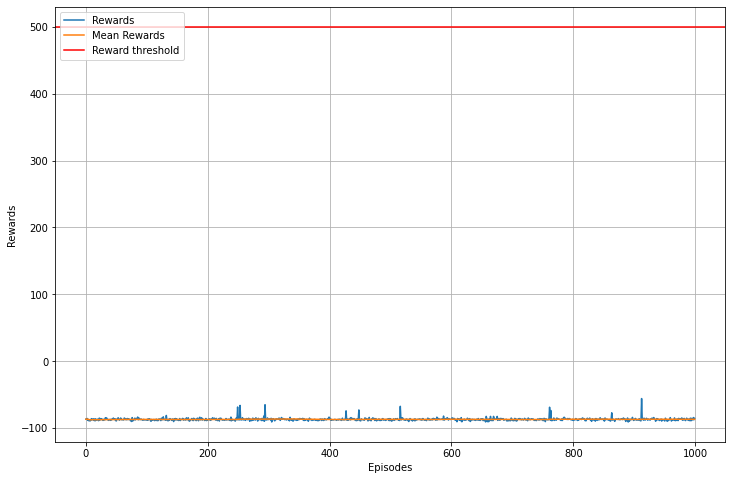

Episode 1067 Mean Rewards -86.79 Last Reward -87.30 n steps 720  epsilon 0.000		

KeyboardInterrupt: ignored

In [13]:
%%time

AC_agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES)

In [15]:
AC_agent.maxS.render()

AttributeError: ignored

In [ ]:
AC_agent.maxS.prodsLog[300]

In [ ]:
AC_agent.plot_rewards()

In [ ]:
myfile = 'agentACDT_Trained_Model.pth'
if os.path.isfile(myfile):
    os.remove(myfile)
torch.save(ACa.state_dict(), myfile)

In [ ]:
%%time

env = gym.envs.make("crudeTanksEnv-v0")

AC = AC_actor(env, 512, learning_rate=0.005, device='cuda')
AC.load_state_dict(torch.load(myfile))

state0 = flat(env.observation_space, env.reset()[0])
done = False
episode_reward = 0
n = 0
action_list = []
while not done:
    cProb, d1Prob, d2Prob = AC.get_action(state0)
    cAction = cProb.sample()
    cAction = torch.clamp(cAction, min=0.1, max=1.0)
    d1Action = d1Prob.sample()
    d2Action = d2Prob.sample()
    action = OrderedDict({'farmTanks': np.array([d1Action.item(), d2Action.item()]),
                          'unitFeed': np.array([cAction.item()])})
    state, reward, done, _, _ = env.step(action)
    state = flat(env.observation_space, state)
    episode_reward += reward
    n += 1
    state0 = deepcopy(state)
    if n >= env.spec.max_episode_steps:
        done = True

print('n: {:4d}   reward: {:4.2f}'.format(n, episode_reward))
env.render()
print('\n')

In [ ]:
list(AC.parameters())

In [ ]:
%%time

env = gym.envs.make("crudeTanksEnv-v0")

AC = AC_actor(env, 512, learning_rate=0.005, device='cuda')
AC.load_state_dict(torch.load(myfile))

reward_list = []
n_list = []
for n_episodes in range(20):
    state0 = flat(env.observation_space, env.reset()[0])
    done = False
    episode_reward = 0
    n = 0
    action_list = []
    while not done:
        cProb, d1Prob, d2Prob = AC.get_action(state0)
        cAction = cProb.sample()
        d1Action = d1Prob.sample()
        d2Action = d2Prob.sample()
        action = OrderedDict({'farmTanks': np.array([d1Action.item(), d2Action.item()]),
                              'unitFeed': np.array([cAction.item()])})
        state, reward, done, _, _ = env.step(action)
        state = flat(env.observation_space, state)
        episode_reward += reward
        n += 1
        state0 = deepcopy(state)
        if n >= env.spec.max_episode_steps:
            done = True

    print('{:2d} n: {:4d}   reward: {:4.2f}'.format(n_episodes+1, n, episode_reward))
    reward_list.append(episode_reward)
print('\n')

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

fig.suptitle('Recompensa de 20 partidas con el modelo ajustado')

ax.plot(reward_list)
ax.axhline(y=env.spec.reward_threshold, color='r', linestyle='-')
ax.set_xlabel('suma de recompensas de cada partida')
ax.set_xticks(range(20))
ax.grid()

plt.show()